In [ ]:
import random

import tqdm
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import pandas as pd
import glob

import tensorflow as tf
from tensorflow_docs.vis import embed
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model

import imageio

import tkinter as tk
from tkinter import ttk, messagebox
from PIL import Image, ImageTk

from IPython import display
from urllib import request

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, mean_squared_log_error, \
    root_mean_squared_error

from pathlib import Path

device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Using device: {device}")

Using device: GPU


In [2]:
SEED = 476
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Data parameters
IMG_SIZE = 224  # MobileNetV2 alapértelmezett mérete

NUM_CLASSES = len(os.listdir("../ExtractedFrames"))  # Pl. len(os.listdir("../ExtractedFrames"))

# Model Hyperparameters

batch_size = 8
epochs = 10
learning_rate = 5.5e-4
criterion = tf.keras.losses.MeanSquaredError()
# criterion = tf.keras.losses.MeanAbsoluteError()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-5)

activation_func = 'relu'


In [4]:
def scheduler(epoch, lr):
    if epoch < 550:
        return lr
    else:
        return lr * np.exp(-0.1)

In [5]:
VIDEO_DIR = "../Videos"
CSV_DIR = "../Annotations"
TIMESTEP = 0.5

# Annotationben a táblák nevei
class_names = ["timestamp", "20","30","50","60","70","80",
               "sebKorlatVege","100","120","elozniTilos",
               "teherautovalElozniTilos","keresztezodesAlarendeltUttal",
               "foutvonal","elsobbsegadas","stop","mind2BehajtaniTilos",
               "teherautovalBehajtaniTilos","behajtaniTilos",
               "veszely","veszelyesKanyarBal","veszelyesKanyarJobb",
               "veszelyesKanyarok","egyenetlenUttsest","csuszos","utszukuletJobbrol",
               "munka","fenyjelzoKeszulek","gyalogosAtkeles","gyerekek",
               "kerekparosok","?","vadVeszely","korlatozasVege",
               "kotelezoHaladasiIranyJobbra","kotelezoHaladasiIranyBalra",
               "kotelezoHaladasiIrany","kotelezoHaladasiIranyJobbraEgyenesen",
               "kotelezoHaladasiIranyBalraEgyenesen","kerulesiIranyJobbra",
               "kerulesiIranyBalra","korforgalom","elozniTilosVege",
               "teherautovalElozniTilosVege","40","autopalya","autopalyaVege",
               "autout","autoutVege","buszmegallo","egyiranyu","foutVege",
               "gyalogosAtkelo","korforgalomPiros","parkolo",
               "szembejovoForgalomnakElsobbseg","szembejovoForgalommalSzembenElsobbseg",
               "utszukulet","utszukuletBalrol","veszelyesKanyarok2","zsakutca",
               "gyalogosok","varakozniTilos","megallniTilos","jobbraKanyarodniTilos",
               "balraKanyarodniTilos","behajtaniTilosMegjeloltDolgokkal",
               "behajtaniTilosKerekparral","kerulesiIranyBalVagyJobb",
               "behajtaniTilosSulykorlat","bukkano"]

len(class_names)

71

In [6]:
# Load videos 
dataset = []
video_filenames = []

for fn in glob.glob("../Videos/*"):
    video_filenames.append(fn)

In [6]:
#for filename in video_filenames:
#    with open(f"../Annotations/{filename[10:-4]}.csv", "w") as f:
#        pass


In [7]:

# Videókhoz csv fájl rendelése
video_filenames = glob.glob("../Videos/*.mp4")

for filename in video_filenames:
    base = os.path.basename(filename)
    name = base[:-4]  # pl. 0001
    csv_path = f"../Annotations/{name}.csv"
    
    # Ha már létezik egy oszlop, azt ne írja felül
    if os.path.exists(csv_path):
        df_existing = pd.read_csv(csv_path)
        for col in class_names:
            if col not in df_existing.columns:
                df_existing[col] = 0
        df_existing.to_csv(csv_path, index=False)
    # Új oszlopot adunk hozzá
    else:
        df = pd.DataFrame(
            data=np.zeros((1000, len(class_names)), dtype=int),
            columns=class_names)
        df["timestamp"] = [x/2 for x in range(0, 1000)]
        df.to_csv(csv_path, index=False)


In [9]:

"""df = pd.DataFrame(
    data=np.zeros((1000, len(class_names)), dtype=int),
    columns=class_names)
df["timestamp"] = [x/2 for x in range(0, 1000, 1)] # TODO: set to video max frame count * x

df

#for filename in video_filenames:    
#    with open(f"../Annotations/{filename[10:-4]}.csv", "w") as f:
#        df.to_csv(f, index=False)
"""


'df = pd.DataFrame(\n    data=np.zeros((1000, len(class_names)), dtype=int),\n    columns=class_names)\ndf["timestamp"] = [x/2 for x in range(0, 1000, 1)] # TODO: set to video max frame count * x\n\ndf\n\n#for filename in video_filenames:    \n#    with open(f"../Annotations/{filename[10:-4]}.csv", "w") as f:\n#        df.to_csv(f, index=False)\n'

In [10]:

"""for filename in video_filenames:
    src = cv2.VideoCapture(str(filename))  
    print("FPS per video:", src.get(cv2.CAP_PROP_FPS ))
    print("Frame per video:",src.get(cv2.CAP_PROP_FRAME_COUNT))
    print("bitrate:",src.get(cv2.CAP_PROP_BITRATE)) 
"""

'for filename in video_filenames:\n    src = cv2.VideoCapture(str(filename))  \n    print("FPS per video:", src.get(cv2.CAP_PROP_FPS ))\n    print("Frame per video:",src.get(cv2.CAP_PROP_FRAME_COUNT))\n    print("bitrate:",src.get(cv2.CAP_PROP_BITRATE)) \n'

In [11]:
# def format_frames(frame, output_size):

    # Pad and resize an image from a video.

    # Args:
    # frame: Image that needs to resized and padded. 
    #  output_size: Pixel size of the output frame image.

   # Return:
  #    Formatted frame with padding of specified output size.
 # """
 # frame = tf.image.convert_image_dtype(frame, tf.float32)
  #frame = tf.image.resize_with_pad(frame, *output_size)
  #return frame

def frames_from_video_file(video_path, n_frames=None, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  result = []
  src = cv2.VideoCapture(str(video_path))  
  
  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  
  if not n_frames:
    n_frames = 1 + (video_length - 1) // frame_step

  need_length = 1 + (n_frames - 1) * frame_step

  # if need_length > video_length:
  #   start = 0
  # else:
  #   max_start = video_length - need_length
  #   start = random.randint(0, max_start + 1)
  
  start = 0

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    # ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
      
  src.release()
  
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [12]:
#sample_video = frames_from_video_file(video_filenames[5], n_frames = 100)
#sample_video.shape

In [13]:
"""def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')
"""

"def to_gif(images):\n  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)\n  imageio.mimsave('./animation.gif', converted_images, fps=10)\n  return embed.embed_file('./animation.gif')\n"

In [14]:
#to_gif(sample_video)

class FrameGenerator:
  def __init__(self, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.training = training
    
    self.class_names = sorted(set(p.name for p in video_filenames.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def __call__(self):

    if self.training:
      random.shuffle()

    for path, name in pairs:
      video_frames = frames_from_video_file(path) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
# Annotator

class VideoAnnotator:
    def __init__(self, root):
        self.root = root
        self.root.title("Közlekedési tábla annotáló")

        self.video_files = sorted(f for f in os.listdir(VIDEO_DIR) if f.endswith(".mp4"))
        self.current_index = 242
    

        self.canvas = tk.Canvas(root, width=1280, height=720)
        self.canvas.grid(row=0, column=0, columnspan=3)

        self.var_dict = {name: tk.IntVar() for name in class_names}
        self.check_frame = tk.Frame(root)
        self.check_frame.grid(row=1, column=0, columnspan=3)

        for i, name in enumerate(class_names):
            cb = tk.Checkbutton(self.check_frame, text=name, variable=self.var_dict[name])
            cb.grid(row=i//10, column=i%10, sticky='w')

        self.time_label = tk.Label(root, text="Idő: 0.0s")
        self.time_label.grid(row=2, column=0)

        self.prev_btn = tk.Button(root, text="<< Vissza", command=self.prev_frame)
        self.prev_btn.grid(row=2, column=1)

        self.next_btn = tk.Button(root, text=">> Előre", command=self.next_frame)
        self.next_btn.grid(row=2, column=2)

        self.root.protocol("WM_DELETE_WINDOW", self.on_closing)

        self.load_video()

    def load_video(self):
        video_file = self.video_files[self.current_index]
        self.cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_file))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

        csv_path = os.path.join(CSV_DIR, video_file.replace(".mp4", ".csv"))
        self.df = pd.read_csv(csv_path)

        self.frame_index = 0
        self.update_frame()

    def update_frame(self):
        timestamp = self.df.iloc[self.frame_index]['timestamp']
        self.time_label.config(text=f"Idő: {timestamp:.1f}s")
        frame_number = int(timestamp * self.fps)
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.resize(frame, (1280, 720))
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            imgtk = ImageTk.PhotoImage(image=img)
            self.canvas.imgtk = imgtk
            self.canvas.create_image(0, 0, anchor='nw', image=imgtk)

        for name in class_names:
            self.var_dict[name].set(int(self.df.iloc[self.frame_index].get(name, 0)))

    def save_frame(self):
        for name in class_names:
            self.df.at[self.frame_index, name] = self.var_dict[name].get()

    def next_frame(self):
        self.save_frame()
        if self.frame_index + 1 < len(self.df):
            self.frame_index += 1
            self.update_frame()
        else:
            self.save_csv()
            messagebox.showinfo("Kész", "Elértél a videó végére.")

    def prev_frame(self):
        self.save_frame()
        if self.frame_index > 0:
            self.frame_index -= 1
            self.update_frame()

    def save_csv(self):
        video_file = self.video_files[self.current_index]
        csv_path = os.path.join(CSV_DIR, video_file.replace(".mp4", ".csv"))
        self.df.to_csv(csv_path, index=False)

    def on_closing(self):
        self.save_frame()
        self.save_csv()
        self.root.destroy()

if __name__ == '__main__':
    root = tk.Tk()
    app = VideoAnnotator(root)
    root.mainloop()

In [ ]:

# Nem jó, mert ez csak single lable


# Képkockák kiszedése

VIDEO_DIR = "../Videos"
CSV_DIR = "../Annotations"
OUTPUT_DIR = "../ExtractedFrames"
IMAGE_SIZE = (256,256)
FRAMES_PER_TIMESTAMP = 3 

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Osztályok listája (timestamp nélkül)
with open(os.path.join(CSV_DIR, os.listdir(CSV_DIR)[0]), 'r') as f:
    header = f.readline().strip().split(',')

COLUMNS = [col for col in header if col != 'timestamp']

for video_file in sorted(os.listdir(VIDEO_DIR)):
    if not video_file.endswith(".mp4"):
        continue

    base_name = os.path.splitext(video_file)[0]
    video_path = os.path.join(VIDEO_DIR, video_file)
    csv_path = os.path.join(CSV_DIR, f"{base_name}.csv")

    df = pd.read_csv(csv_path)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    for _, row in df.iterrows():
        timestamp = row['timestamp']
        active_labels = [label for label in COLUMNS if row.get(label, 0) == 1]
        if not active_labels:
            continue

        # Időbélyeg képkockaszámra
        center_frame = int(timestamp * fps)
        offsets = [-1, 0, 1]  # 3 frame: középső + 1 előtte + 1 utána

        for offset in offsets:
            frame_num = center_frame + offset
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if not ret:
                continue

            resized = cv2.resize(frame, IMAGE_SIZE)

            for label in active_labels:
                label_dir = os.path.join(OUTPUT_DIR, label)
                os.makedirs(label_dir, exist_ok=True)
                filename = f"{base_name}_{timestamp:.1f}_{frame_num}.jpg"
                path = os.path.join(label_dir, filename)
                cv2.imwrite(path, resized)

    cap.release()

print("Képkockák mentése kész.")


Képkockák mentése kész.


In [10]:

# Ez tölti be jól a képeket, és hoz létre egy labels.csv fájlt hozzá!

import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm


VIDEO_DIR = "../Videos"
CSV_DIR = "../Annotations"
OUTPUT_DIR = "../MultiLabelFrames"
LABEL_CSV_PATH = os.path.join(OUTPUT_DIR, "labels.csv")
IMAGE_SIZE = (512, 512)
FRAMES_PER_TIMESTAMP = 3

# Hozzuk létre a célmappát
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Oszlopnevek beolvasása az első CSV fájlból
sample_csv = os.path.join(CSV_DIR, os.listdir(CSV_DIR)[0])
with open(sample_csv, 'r') as f:
    header = f.readline().strip().split(',')
COLUMNS = [col for col in header if col != 'timestamp']

# Itt tároljuk a fájlneveket és címkéket
file_records = []

# Videók feldolgozása
for video_file in tqdm(sorted(os.listdir(VIDEO_DIR))):
    if not video_file.endswith(".mp4"):
        continue

    base_name = os.path.splitext(video_file)[0]
    video_path = os.path.join(VIDEO_DIR, video_file)
    csv_path = os.path.join(CSV_DIR, f"{base_name}.csv")

    if not os.path.exists(csv_path):
        print(f"Hiányzó CSV: {csv_path}")
        continue

    df = pd.read_csv(csv_path)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    for _, row in df.iterrows():
        timestamp = row['timestamp']
        active_labels = [label for label in COLUMNS if row[label] == 1]
        if not active_labels:
            continue

        center_frame = int(timestamp * fps)
        offsets = [-1, 0, 1]  # 3 képkocka

        for offset in offsets:
            frame_num = center_frame + offset
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if not ret:
                continue

            resized = cv2.resize(frame, IMAGE_SIZE)

            # Fájlnév létrehozása
            filename = f"{base_name}_{timestamp:.1f}_{frame_num}.jpg"
            filepath = os.path.join(OUTPUT_DIR, filename)
            cv2.imwrite(filepath, resized)

            # Címkék 0/1 listaként
            label_vector = [int(label in active_labels) for label in COLUMNS]
            file_records.append([filename] + label_vector)

    cap.release()

# Címkék mentése CSV-be
label_df = pd.DataFrame(file_records, columns=["filename"] + COLUMNS)
label_df.to_csv(LABEL_CSV_PATH, index=False)

print("Képkockák és címkék elmentve a multi-label tanításhoz.")


100%|██████████| 244/244 [07:24<00:00,  1.82s/it]


Képkockák és címkék elmentve a multi-label tanításhoz.


In [21]:
import tensorflow as tf
import pandas as pd
from pathlib import Path

# --- Útvonalak ---
DATASET_PATH = Path("D:/Szakdolgozat/githubclone/kozlekedesi_tabla_felismero/MultiLabelFrames")
CSV_PATH = DATASET_PATH / "labels.csv"

# --- Paraméterek ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# --- CSV beolvasása ---
df = pd.read_csv(CSV_PATH)

# Elérési utak és címkék elkészítése
image_paths = [str(DATASET_PATH / fname) for fname in df["filename"]]
labels = df.drop(columns=["filename"]).values.astype("float32")

# --- Kép betöltő függvény ---
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

# --- tf.data.Dataset elkészítése ---
full_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
full_ds = full_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
full_ds = full_ds.shuffle(buffer_size=1000, seed=42)

# --- Train/Val szétválasztás ---
total_size = len(image_paths)
train_size = int(total_size * 0.8)

train_ds = full_ds.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = full_ds.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Osztálynevek elmentése külön listába (későbbi predikcióhoz hasznos) ---
sign_names = df.columns.drop("filename").tolist()

print(f"✅ Dataset betöltve. Képek száma: {total_size}, Címkék száma: {len(sign_names)}")


✅ Dataset betöltve. Képek száma: 8501, Címkék száma: 49


In [22]:

# --- Modell építés ---

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(sign_names), activation='sigmoid')  # multi-label kimenet
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [23]:

# --- Tanítás ---

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
213/213 [==============================] - 16s 62ms/step - loss: 0.1228 - AUC: 0.7909 - precision: 0.2299 - recall: 0.1007 - val_loss: 0.1065 - val_AUC: 0.8562 - val_precision: 0.6089 - val_recall: 0.0633
Epoch 2/20
213/213 [==============================] - 13s 59ms/step - loss: 0.0856 - AUC: 0.9032 - precision: 0.6098 - recall: 0.1622 - val_loss: 0.0973 - val_AUC: 0.8862 - val_precision: 0.7221 - val_recall: 0.1117
Epoch 3/20
213/213 [==============================] - 13s 60ms/step - loss: 0.0742 - AUC: 0.9364 - precision: 0.7104 - recall: 0.2327 - val_loss: 0.0957 - val_AUC: 0.8942 - val_precision: 0.7018 - val_recall: 0.1380
Epoch 4/20
213/213 [==============================] - 13s 59ms/step - loss: 0.0655 - AUC: 0.9546 - precision: 0.7517 - recall: 0.2971 - val_loss: 0.0882 - val_AUC: 0.9090 - val_precision: 0.7057 - val_recall: 0.1842
Epoch 5/20
213/213 [==============================] - 13s 59ms/step - loss: 0.0589 - AUC: 0.9664 - precision: 0.7744 - recall: 0.3624 - 

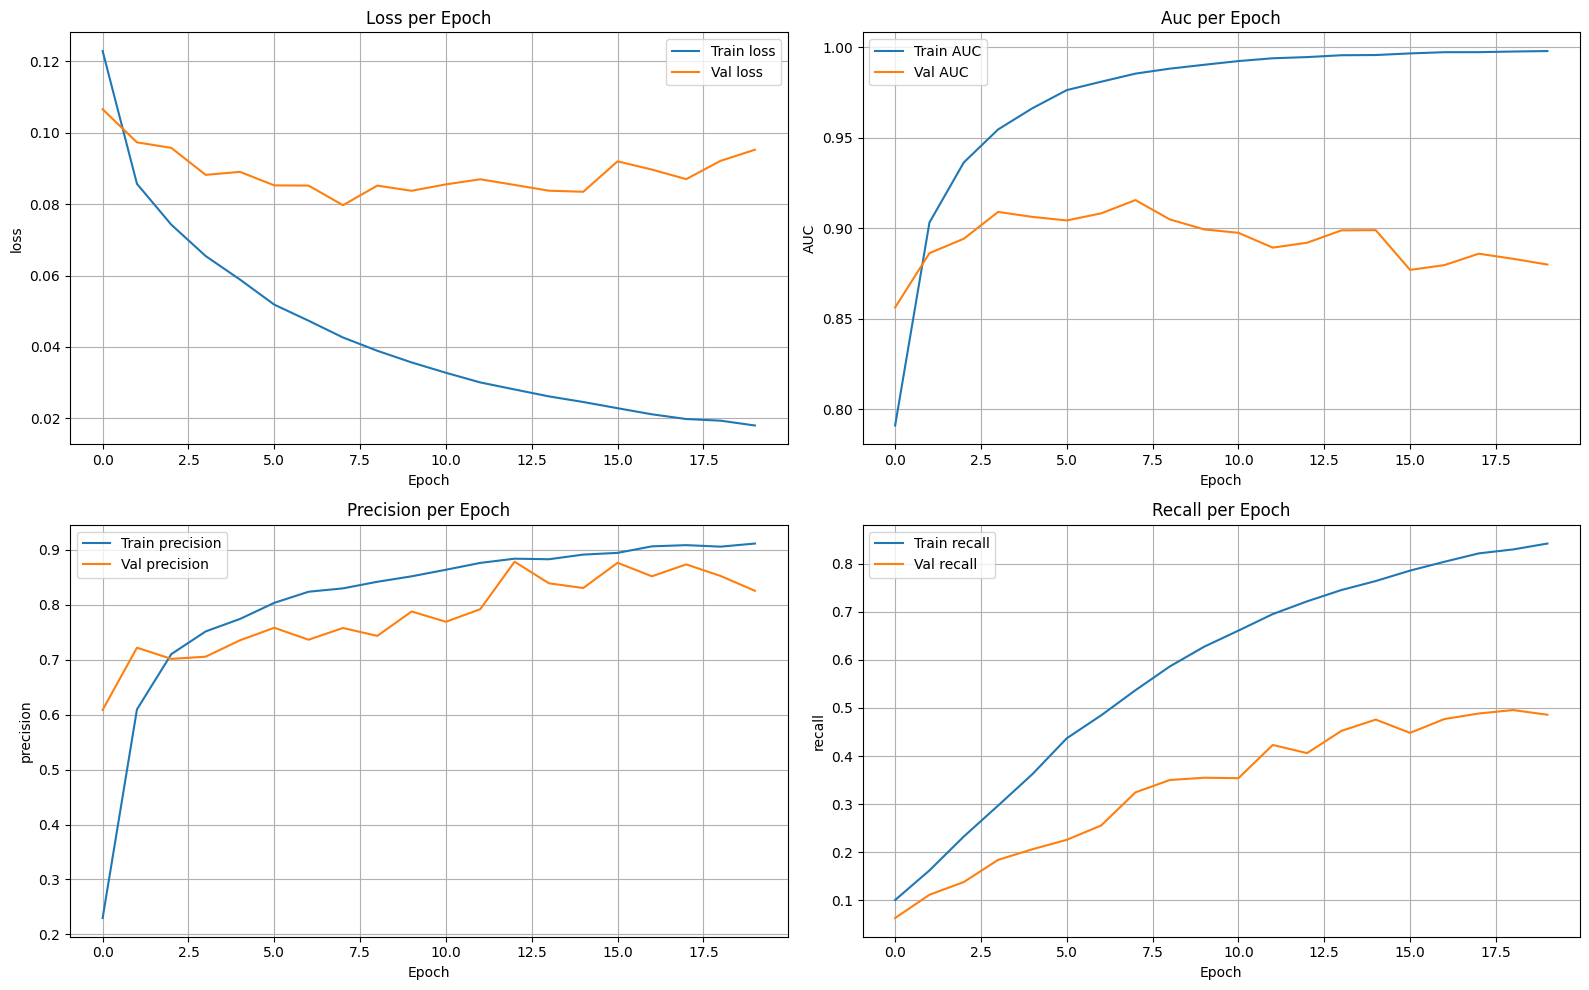

In [25]:

# --- Grafikon rajzolás ---
def plot_training_history(history):
    metrics = ['loss', 'AUC', 'precision', 'recall']
    
    plt.figure(figsize=(16, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric.capitalize()} per Epoch')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [7]:
print(sign_names)

['30', '50', '60', '70', 'elozniTilos', 'keresztezodesAlarendeltUttal', 'foutvonal', 'elsobbsegadas', 'stop', 'mind2BehajtaniTilos', 'teherautovalBehajtaniTilos', 'behajtaniTilos', 'veszely', 'veszelyesKanyarBal', 'veszelyesKanyarJobb', 'veszelyesKanyarok', 'egyenetlenUttsest', 'csuszos', 'utszukuletJobbrol', 'munka', 'fenyjelzoKeszulek', 'gyalogosAtkeles', 'gyerekek', 'kerekparosok', 'vadVeszely', 'korlatozasVege', 'kotelezoHaladasiIranyJobbra', 'kotelezoHaladasiIrany', 'kerulesiIranyJobbra', 'kerulesiIranyBalra', 'korforgalom', '40', 'buszmegallo', 'egyiranyu', 'foutVege', 'gyalogosAtkelo', 'korforgalomPiros', 'parkolo', 'utszukulet', 'zsakutca', 'gyalogosok', 'varakozniTilos', 'megallniTilos', 'balraKanyarodniTilos', 'behajtaniTilosMegjeloltDolgokkal', 'behajtaniTilosKerekparral', 'kerulesiIranyBalVagyJobb', 'behajtaniTilosSulykorlat', 'bukkano']


In [24]:
# --- .h5 formátumban mentés ---
model.save("D:/Szakdolgozat/githubclone/kozlekedesi_tabla_felismero/mentett_model/multilabel_model.h5")
print("✅ Modell elmentve .h5 formátumban.")

# --- SavedModel formátumban mentés ---
model.save("D:/Szakdolgozat/githubclone/kozlekedesi_tabla_felismero/mentett_model/multilabel_model_saved", save_format="tf")
print("✅ Modell elmentve SavedModel formátumban.")


✅ Modell elmentve .h5 formátumban.


INFO:tensorflow:Assets written to: D:/Szakdolgozat/githubclone/kozlekedesi_tabla_felismero/mentett_model/multilabel_model_saved\assets


INFO:tensorflow:Assets written to: D:/Szakdolgozat/githubclone/kozlekedesi_tabla_felismero/mentett_model/multilabel_model_saved\assets


✅ Modell elmentve SavedModel formátumban.


In [ ]:
# Without Tranfer Learning / Alap CNN modell

# Osztályok száma a címkék alapján
num_classes = train_ds.element_spec[1].shape[-1]

# Modell definíció
model = models.Sequential([
    layers.Input(shape=(512, 512, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')  # multi-label!
])

# Kompilálás binary_crossentropy-vel (multi-label esetén kötelező)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Alap CNN modell tanítása

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
213/213 [==============================] - 117s 448ms/step - loss: 0.1044 - accuracy: 0.1535 - val_loss: 0.0885 - val_accuracy: 0.1088
Epoch 2/10
213/213 [==============================] - 90s 420ms/step - loss: 0.0766 - accuracy: 0.1681 - val_loss: 0.0882 - val_accuracy: 0.0658
Epoch 3/10
213/213 [==============================] - 89s 417ms/step - loss: 0.0765 - accuracy: 0.1731 - val_loss: 0.0899 - val_accuracy: 0.1129
Epoch 4/10
213/213 [==============================] - 91s 423ms/step - loss: 0.0765 - accuracy: 0.1701 - val_loss: 0.0881 - val_accuracy: 0.0617
Epoch 5/10
213/213 [==============================] - 91s 426ms/step - loss: 0.0762 - accuracy: 0.1719 - val_loss: 0.0892 - val_accuracy: 0.1017
Epoch 6/10
213/213 [==============================] - 90s 420ms/step - loss: 0.0762 - accuracy: 0.1688 - val_loss: 0.0906 - val_accuracy: 0.1064
Epoch 7/10
213/213 [==============================] - 90s 419ms/step - loss: 0.0760 - accuracy: 0.1696 - val_loss: 0.0927 - val_a

In [10]:
# Transfer Learning

# Osztályok száma (automatikusan kinyerhető, ha train_ds már létezik)
num_classes = train_ds.element_spec[1].shape[-1]

IMAGE_SIZE = (224)

# Transfer learning alapmodell (ImageNet-ről)
base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # nem tanítjuk újra az alap CNN-t

# Végső modell
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='sigmoid')  # több címkére egyszerre
])

# Kompilálás jobb metrikákkal
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print(num_classes)

49


In [11]:

# Tanítás
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 512, 512, 3)


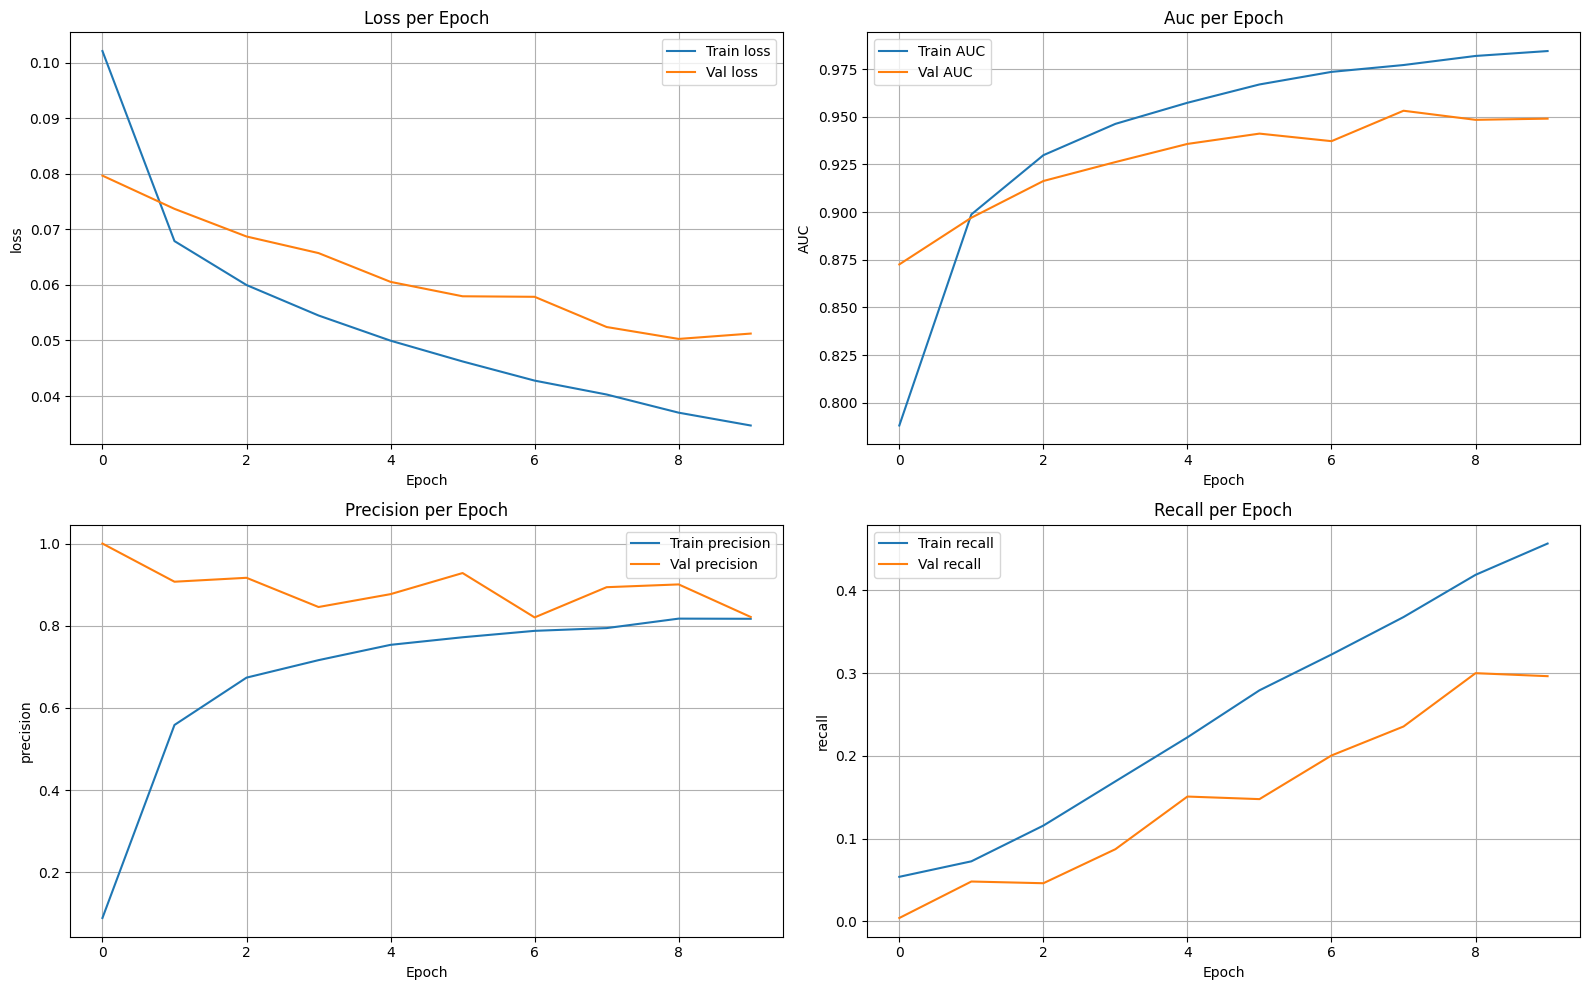

In [14]:
# --- Grafikonok rajzolása ---
def plot_training_history(history):
    metrics = ['loss', 'AUC', 'precision', 'recall']
    
    plt.figure(figsize=(16, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric.capitalize()} per Epoch')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Modell összefoglaló
model.summary()

In [8]:
def recall_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)    
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:

# Újra betöltjük a train_ds-t és val_ds-t megfelelő képmérettel + preprocess_input
train_ds = tf.keras.utils.image_dataset_from_directory(
    "../ExtractedFrames",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "../ExtractedFrames",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size
)

# Normalizálás a MobileNetV2-hez illően
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

# Prefetch az adatfolyam gyorsításához
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 11942 files belonging to 49 classes.
Using 9554 files for training.
Found 11942 files belonging to 49 classes.
Using 2388 files for validation.


In [ ]:
# Alapmodell betöltése (ImageNet-ről előtanított súlyokkal
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,  # Ne tartalmazza az eredeti kimeneti réteget
                         weights='imagenet')

base_model.trainable = False  # Nem tanítjuk az alapmodell rétegeit (csak a fejet)

# Modell felépítése
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='relu'),
    layers.Dense(
        NUM_CLASSES, 
        activation='sigmoid')
])


In [12]:

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 
                                                            f1_m, 
                                                            precision_m, recall_m])

# Modell tanítása
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10


ValueError: in user code:

    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 49) vs (None, 1)).


In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               327936    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 49)                12593     
                                                                 
Total params: 2,598,513
Trainable params: 340,529
Non-

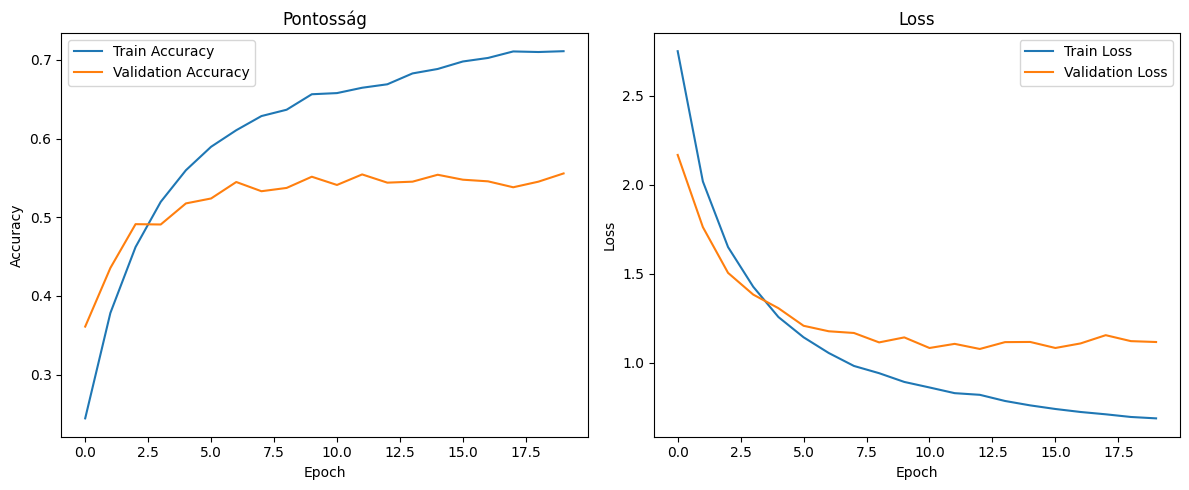

In [38]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Pontosság')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Modell mentése .h5 fájlba
model.save("traffic_sign_model.h5")
# Modell mentése SaveModel formátumban
model.save("D:/Szakdolgozat/traffic_sign_model")  # mappa lesz belőle

INFO:tensorflow:Assets written to: D:/Szakdolgozat/traffic_sign_model\assets


INFO:tensorflow:Assets written to: D:/Szakdolgozat/traffic_sign_model\assets


In [ ]:
# --- Beállítások ---
MODEL_PATH = "model.h5"  
LABELS_PATH = "sign_names.npy"
IMG_PATH = "test_image.jpg"  # Cseréld ki a saját képedre
IMG_SIZE = (512, 512)  # Ugyanakkora legyen, mint a tanításhoz

# --- Modell és címkék betöltése ---
model = load_model("../traffic_sign_model")
sign_names = np.load(LABELS_PATH)


In [ ]:

# --- Kép betöltése és előfeldolgozása ---
img = image.load_img(IMG_PATH, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalizálás
img_array = np.expand_dims(img_array, axis=0)  # (1, 512, 512, 3)

# --- Predikció ---
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions[0])
predicted_label = sign_names[predicted_index]
confidence = np.max(predictions[0])

# --- Eredmény kiírása ---
print(f"Predikált tábla: {predicted_label} ({confidence*100:.2f}% biztonsággal)")

# --- Kép megjelenítése ---
plt.imshow(img)
plt.title(f"Predikció: {predicted_label}")
plt.axis('off')
plt.show()


In [16]:
len(os.listdir("../ExtractedFrames"))

49

In [ ]:


model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # mivel integer címkéid vannak
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

Found 11942 files belonging to 49 classes.
Using 9554 files for training.
Found 11942 files belonging to 49 classes.
Using 2388 files for validation.


(48, 48)

In [15]:
fg = FrameGenerator(training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

NameError: name 'FrameGenerator' is not defined

In [16]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(#  10, 
                                                         training=True),
                                          output_signature = output_signature)

NameError: name 'FrameGenerator' is not defined

In [17]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(training=False),
                                        output_signature = output_signature)

NameError: name 'FrameGenerator' is not defined

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size = AUTOTUNE)

In [10]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (8, 512, 512, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 512, 512, 3)
Shape of validation labels: (8,)


In [11]:
train_ds = train_ds.batch(2).unbatch()
val_ds = val_ds.batch(2).unbatch()

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (8, 512, 512, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 512, 512, 3)
Shape of validation labels: (8,)


In [ ]:
# Eelvileg emiatt omlik ossze a program
# Átalakítás numpy tömbökké
train_ds = np.array(train_ds) 
val_ds = np.array(val_ds) 

train_ds

array(<BatchDataset element_spec=(TensorSpec(shape=(None, None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>,
      dtype=object)

In [22]:

train_labels = to_categorical(train_labels, num_classes)  # One-hot encoding
test_labels = to_categorical(test_labels, num_classes)

NameError: name 'num_classes' is not defined

In [13]:

print(train_labels[0])


tf.Tensor(16, shape=(), dtype=int32)


In [23]:

train_ds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_ds, dtype=tf.float32)))
val_ds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(val_ds, dtype=tf.float32)))

train_loader = train_ds.batch(batch_size, drop_remainder=True) # .shuffle(buffer_size=len(train_images))
val_loader = val_ds.batch(batch_size, drop_remainder=True) # .shuffle(buffer_size=len(test_images))



ValueError: Attempt to convert a value (<_UnbatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops._UnbatchDataset'>) to a Tensor.

In [ ]:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

# Extract images and labels as numpy arrays
#EZ IS BAJ ELVILEG
train_images, train_labels = dataset_to_numpy(train_ds.batch(8))

val_images, val_labels = dataset_to_numpy(val_ds.batch(8))

# Create datasets using from_tensor_slices

# train_ds_new = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# val_ds_new = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

# del train_ds_new
# del val_ds_new

# Create data loaders with batching
# train_loader = train_ds_new.batch(batch_size, drop_remainder=True)
# val_loader = val_ds_new.batch(batch_size, drop_remainder=True)

# Add shuffling to training data

buffer_size = 16  
# train_loader = train_loader.shuffle(buffer_size=buffer_size)


In [1]:
train_loader_alt = train_ds.batch(batch_size, drop_remainder=True)
val_loader_alt = val_ds.batch(batch_size, drop_remainder=True)

NameError: name 'train_ds' is not defined

In [ ]:

class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()

        self.input_layer = tf.keras.layers.Dense(
            input_shape=(batch_size, IMG_SIZE, IMG_SIZE, 3), 
            units=256,
            activation=activation_func
        )

        # self.feature_extractor = []
        # for i in range(5):
        #     self.hidden_layers.append(tf.keras.layers.Dense(2048, activation=activation_func))
        #     self.hidden_layers.append(tf.keras.layers.Dropout(0.2))

        self.hidden_layers = []
        for i in range(2):
            self.hidden_layers.append(tf.keras.layers.Dense(256, activation=activation_func))
            self.hidden_layers.append(tf.keras.layers.Dropout(0.2))
            self.hidden_layers.append(tf.keras.layers.BatchNormalization())

        # self.additional_layers = []
        # for i in range(2):
        #     self.additional_layers.append(tf.keras.layers.Dense(256, activation=activation_func))
        #     self.additional_layers.append(tf.keras.layers.Dropout(0.2))
        self.output_layer = tf.keras.layers.Dense(NUM_CLASSES), activation='softmax')

    def call(self, x):
        x = self.input_layer(x)
        # for layer in self.feature_extractor:
        #     x = layer(x)
        for layer in self.hidden_layers:
            x = layer(x)# for layer in self.additional_layers:
        #     x = layer(x)

        return self.output_layer(x)
    
model = Net()

NameError: name 'batch_size' is not defined

In [ ]:
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(train_loader, epochs=num_epochs, validation_data=val_loader, verbose=1)

Epoch 1/5


ValueError: in user code:

    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\fabia\AppData\Local\Temp\__autograph_generated_filer493t7fb.py", line 24, in tf__call
        ag__.for_stmt(ag__.ld(self).hidden_layers, None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'layer'})
    File "C:\Users\fabia\AppData\Local\Temp\__autograph_generated_filer493t7fb.py", line 22, in loop_body
        x = ag__.converted_call(ag__.ld(layer), (ag__.ld(x),), None, fscope)

    ValueError: Exception encountered when calling layer "net_3" "                 f"(type Net).
    
    in user code:
    
        File "C:\Users\fabia\AppData\Local\Temp\ipykernel_4900\3739073957.py", line 33, in call  *
            x = layer(x)# for layer in self.additional_layers:
        File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "batch_normalization_16" is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: (None, 512, 512, 256)
    
    
    Call arguments received by layer "net_3" "                 f"(type Net):
      • x=tf.Tensor(shape=(None, 512, 512, 3), dtype=float32)


In [ ]:
train_loader = train_loader_alt
val_loader = val_loader_alt

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(train_loader):
        with tf.GradientTape() as tape:
            outputs = model(batch_x, training=True)
            loss = criterion(batch_y, tf.squeeze(outputs))

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_loss += loss.numpy()

    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    val_loss = 0
    for batch_x, batch_y in val_loader:
        outputs = model(batch_x, training=False)
        loss = criterion(batch_y, tf.squeeze(outputs))
        val_loss += loss.numpy()

    val_losses.append(val_loss / len(val_loader))

    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Train Loss: {train_loss / len(train_loader):.4f}, "
        f"Validation Loss: {val_loss / len(val_loader):.4f}"
    )

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)


Epoch 1/5


ResourceExhaustedError: Exception encountered when calling layer "dense_21" "                 f"(type Dense).

{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[16777216,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]

Call arguments received by layer "dense_21" "                 f"(type Dense):
  • inputs=tf.Tensor(shape=(8, 8, 512, 512, 3), dtype=float32)

In [36]:

# Making predictions
x_train_tensor = tf.convert_to_tensor(train_ds, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(val_ds, dtype=tf.float32)

y_train_pred = model(x_train_tensor, training=False).numpy()
y_test_pred = model(x_test_tensor, training=False).numpy()


ValueError: Attempt to convert a value (<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>) to a Tensor.

In [ ]:
model.summary()

In [ ]:

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Train R-squared: {train_r2 * 100:.2f}%')
print(f'Test R-squared: {test_r2 * 100:.2f}%')
print(f'Test Mean Squared Error (MSE): {test_mse:.2f}')
print(f'Test Root Mean Squared Error (RMSE): {test_rmse:.2f}')
print(f'Test Mean Absolute Error (MAE): {test_mae:.2f}')

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual', marker='o', linestyle='None')
plt.plot(y_test_pred, label='Predicted', marker='x', linestyle='None')
plt.legend()
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

print(model.summary())
print(model.get_config())
print(optimizer.get_config())

model.save("HousePrices/saved_models/nn_model_" + exp_name + ".tf",
            save_format='tf')

NameError: name 'r2_score' is not defined